# 1st go at playing with HARPS-N solar CCFs 

Suzanne Aigrain @ Oxford, May 2019

In [3]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


Read in CCFs from 2018 and select very quiet period when the Jupiter RV signal is approx constant to construct CCF reference.

In [8]:
year = '2018'
with open('../data/HARPN_Sun/ccf_'+year,'rb') as infile:
    ccfYear = pickle.load(infile)
nobs,nvel = np.shape(ccfYear)
crval1 = -20
cdelt1 = 0.25
vel = np.arange(nvel)*cdelt1 + crval1

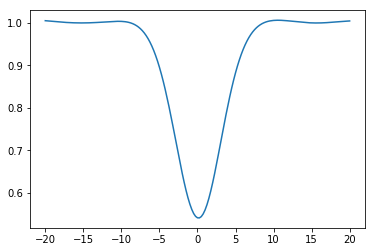

In [9]:
ccfRef = np.mean(ccfYear[125:150,:],axis=0)
plt.plot(vel,ccfRef)

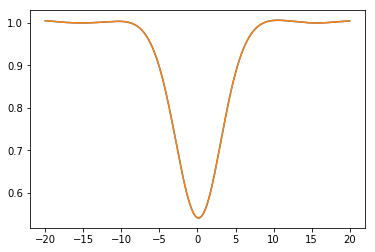

In [14]:
from george import GP, kernels
k = 0.1 * kernels.ExpSquaredKernel(1.0) + 0.5 * kernels.LocalGaussianKernel(location=0.0,log_width=np.log(9.0))
gp = GP(k)
gp.compute(vel)
mu = gp.predict(vel,ccfRef,return_var=False,return_cov=False)
plt.plot(vel,ccfRef)
plt.plot(vel,mu)
ccfRef_ = ccfRef.copy()
ccfRef = mu

### <font color=red>Should really replace this with a GP fit to...</font>

Now read 2017 CCFs (slightly more active)

In [16]:
year = '2017'
with open('../data/HARPN_Sun/ccf_'+year,'rb') as infile:
    ccfYear = pickle.load(infile)
nobs,nvel = np.shape(ccfYear)

Unpack BJD, average daily heliocentric RVs corrected for bad weather and differential extinction, and solar barycentric velocity.

(83, 6)
(242, 6)
(199, 6)
(208, 6)


(-0.03, -0.01)

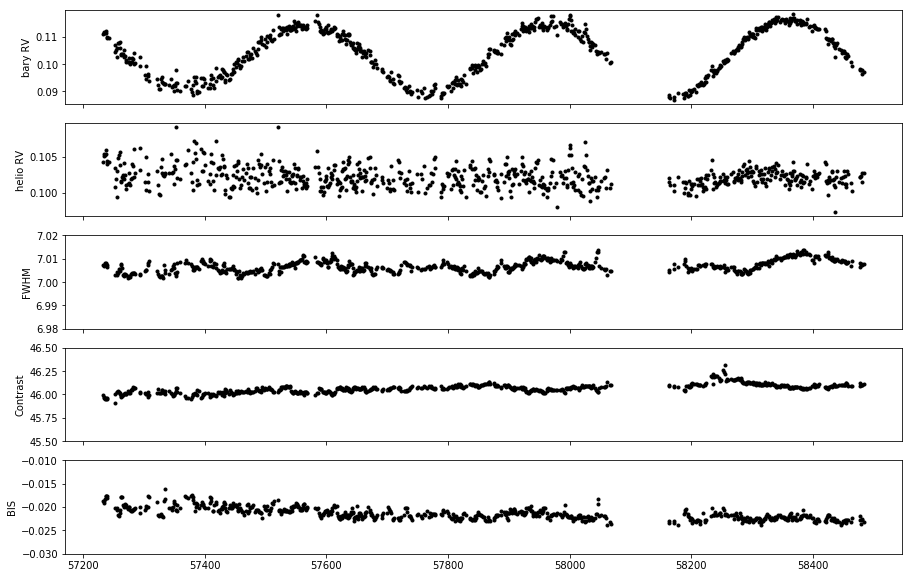

In [43]:
fig, axes = plt.subplots(5,1,figsize=(15,10),sharex=True)
years = ['2015','2016','2017','2018']
for year in years:
    with open('../data/HARPN_Sun/vel_'+year,'rb') as infile:
        velYear = pickle.load(infile)
    bjd = velYear[:,0]
    rvh = velYear[:,1]
    bsrv = velYear[:,2]
    fwhm = velYear[:,3]
    cont = velYear[:,4]
    bis = velYear[:,5]
    print(velYear.shape)
    rvb = rvh - bsrv
    axes[0].plot(bjd,rvb,'k.')
    axes[1].plot(bjd,rvh,'k.')
    axes[2].plot(bjd,fwhm,'k.')
    axes[3].plot(bjd,cont,'k.')
    axes[4].plot(bjd,bis,'k.')
axes[0].set_ylabel('bary RV')
axes[1].set_ylabel('helio RV')
axes[2].set_ylabel('FWHM')
axes[2].set_ylim(6.98,7.02)
axes[3].set_ylabel('Contrast')
axes[3].set_ylim(45.5,46.5)
axes[4].set_ylabel('BIS')
axes[4].set_ylim(-0.03,-0.01)
#plt.xlim(57580,57730)


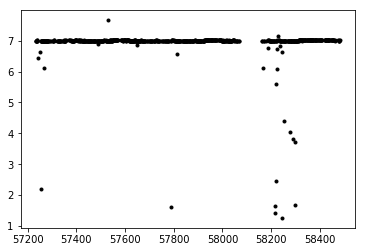

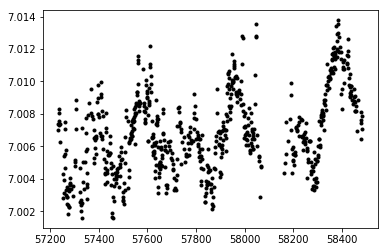

In [42]:
years = ['2015','2016','2017','2018']
bjd = []
fwhm = []
for i, year in enumerate(years):
    with open('../data/HARPN_Sun/vel_'+year,'rb') as infile:
        velYear = pickle.load(infile)
    if i == 0: 
        bjd = velYear[:,0]
        fwhm = velYear[:,3]
    else:
        bjd = np.concatenate([bjd,velYear[:,0]]).flatten()
        fwhm = np.concatenate([fwhm,velYear[:,3]]).flatten()
plt.figure()
plt.plot(bjd,fwhm,'k.')
m = np.median(fwhm)
s = 1.48 * np.median(abs(fwhm-m))
l = abs(fwhm-m) < 3 * s
plt.figure()
plt.plot(bjd[l],fwhm[l],'k.')


Display residual CCF timeseries.

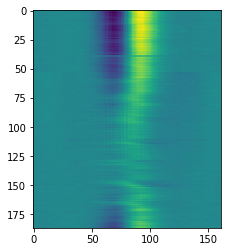

In [39]:
plt.imshow(ccfYear - ccfRef)

Plot average daily heliocentric RVs corrected for bad weather and differential extinction.

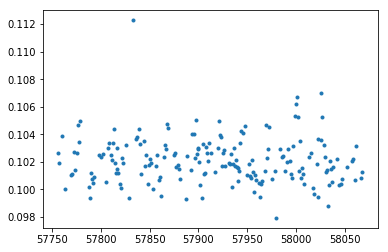

In [40]:
plt.plot(bjd,rvh,'.')

Plot average daily barycentric RVs corrected for bad weather and differential extinction.

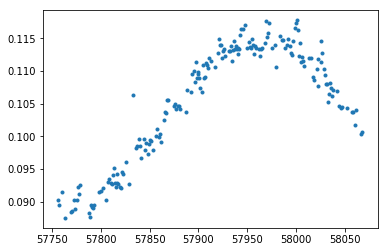

In [41]:
plt.plot(bjd,rvb,'.')

In [42]:
d0 = ccfRef
dmin,dmax = d0.min(),d0.max()
x1 = (d0-dmin)/(dmax-dmin)
d0p = np.append(d0[1:]-d0[:-1],0)
dmin,dmax = d0p.min(),d0p.max()
x2 = (d0p-dmin)/(dmax-dmin)
d0pp = np.append(0,d0p[1:]-d0p[:-1])
dmin,dmax = d0pp.min(),d0pp.max()
x3 = (d0pp-dmin)/(dmax-dmin)

In [43]:
from scipy.optimize import minimize
p1 = np.zeros((len(bjd),4))
ccfMod = np.zeros_like(ccfYear)
ccfMod1 = np.zeros_like(ccfYear)
ccfMod2 = np.zeros_like(ccfYear)
coeffs = np.zeros((len(bjd),4))
for i in range(len(bjd)):
    d = ccfYear[i,:].flatten()
    y = d - d0
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3
        return m
    def nll(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(4)
    soln = minimize(nll,p0,args=(y))
    p1[i,:] = soln.x
    ccfMod[i,:] = model(soln.x)
    pp = np.copy(soln.x)
    pp[0] = 0
    pp[2] = 0
    ccfMod1[i,:] = model(pp)
    pp = np.copy(soln.x)
    pp[1] = 0
    pp[3] = 0
    ccfMod2[i,:] = model(pp)

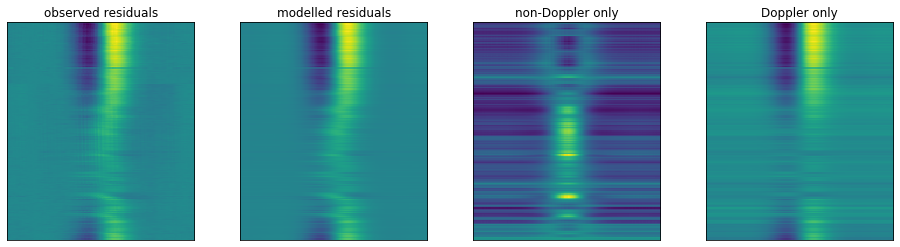

In [44]:
fig,axes=plt.subplots(1,4,sharex=True,figsize = (16,4))
axes[0].imshow(ccfYear - ccfRef)
axes[1].imshow(ccfMod)
axes[2].imshow(ccfMod1)
axes[3].imshow(ccfMod2)
axes[0].xaxis.set_visible(False) 
axes[0].yaxis.set_visible(False) 
axes[1].xaxis.set_visible(False) 
axes[1].yaxis.set_visible(False) 
axes[2].xaxis.set_visible(False) 
axes[2].yaxis.set_visible(False) 
axes[3].xaxis.set_visible(False) 
axes[3].yaxis.set_visible(False) 
axes[0].set_title('observed residuals')
axes[1].set_title('modelled residuals')
axes[2].set_title('non-Doppler only')
axes[3].set_title('Doppler only')
plt.savefig('diff_ccf.png')

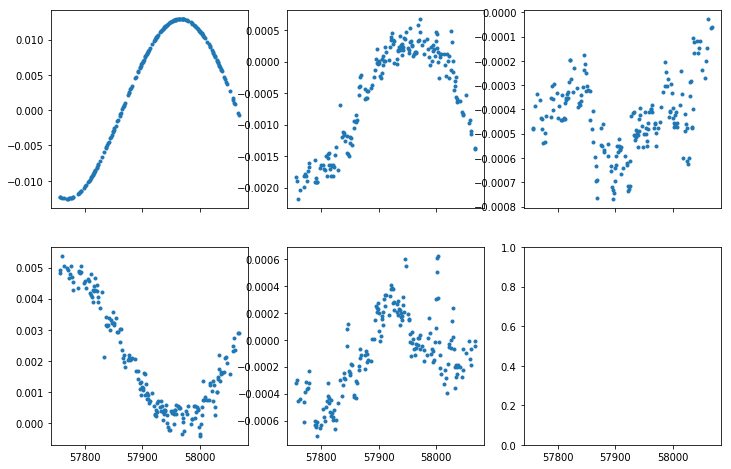

In [46]:
fig,axes=plt.subplots(2,3,sharex=True,figsize = (12,8))
rvpl = rvb-rvh
axes[0,0].plot(bjd,rvpl,'.')
axes[0,1].plot(bjd,p1[:,0].flatten(),'.')
axes[0,2].plot(bjd,p1[:,1].flatten(),'.')
axes[1,0].plot(bjd,p1[:,2].flatten(),'.')
axes[1,1].plot(bjd,p1[:,3].flatten(),'.')
